In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
print(tf.__version__)

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

from collections import Counter

2.2.0


In [2]:
SEED = 114
np.random.seed(SEED)

## Task b)

The next problem will require you to build a classifier and test its properties. Pick
a multi-class text classification dataset that is not already tokenized. One example
is a dataset of New York Times headlines and topics (Boydstun, 2013). Divide your
data into training (60%), development (20%), and test sets (20%), if no such division
already exists. If your dataset is very large, you may want to focus on a few thousand
instances at first.

#### Importing and pre-processing

In [3]:
data = pd.read_csv("boydstun_nyt_frontpage_dataset_1996-2006_0_pap2014_recoding_updated2018.csv", encoding = "ISO-8859-1")
print(data.shape)

(31034, 6)


In [4]:
data.head()

,id,year,majortopic,subtopic,title,summary
0,1,1996,12,1205,Nation's Smaller Jails Struggle To Cope With S...,Jails overwhelmed with hardened criminals
1,2,1996,23,2300,Dancing (and Kissing) In the New Year,new years activities
2,3,1996,20,2012,Forbes's Silver Bullet for the Nation's Malaise,Steve Forbes running for President
3,4,1996,16,1602,"Up at Last, Bridge to Bosnia Is Swaying Gatewa...",U.S. military constructs bridge to help their ...
4,5,1996,20,2012,2 SIDES IN SENATE DISAGREE ON PLAN TO END FURL...,Democrats and Republicans can't agree on plan ...


In [5]:
# Select relevant fields
data = data.loc[:,["majortopic","title"]].values

# Move to label array and text array
#y = data["majortopic"].values
#X_raw = data["title"].values


In [6]:
# Tokenize data

tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+,')

tokenized_titles = []
y = []
for title in data:
    if isinstance(title[1], str):
        processed = tokenizer.tokenize(title[1])
        tokenized_titles.append(processed)
        y.append(title[0])
y = np.array(y)

In [7]:
# Map y's to integers between 0 and num_labels
num_labels = len(set(y))
print(num_labels)
label_mapping = {}
for i,j in enumerate(set(y)):
    label_mapping[j] = i
y = np.array([label_mapping[entry] for entry in y])

28


In [8]:
# Change to lower case and remove one letter words

reduced_titles = []
for title in tokenized_titles:
    new = []
    for word in title:
        if len(word) > 1:
            word = word.lower()
            new.append(word)
    reduced_titles.append(new)

### i)

Compare various vocabulary sizes of 10^2, 10^3, 10^4, 10^5, using the most frequent
words in each case. Train log-linear models, using feature extraction methods
discussed in Lecture 3, for each vocabulary size. Plot the accuracy and macro
F-measure on the test set with the increasing vocabulary size.

In [9]:
# First, construct vocabulary lists of the above sizes
# These are then used when vectorizing the titles, only vectorize word if contained in vocab

full_word_list = [item for sublist in reduced_titles for item in sublist]


In [10]:
frequencies = Counter(full_word_list).most_common()

# create vocabs
vocab_100 = set([item for item,_ in frequencies[:100]])
vocab_1000 = set([item for item,_ in frequencies[:1000]])
vocab_10000 = set([item for item,_ in frequencies[:10000]])
vocab_full = set(full_word_list)

### GloVe pre-trained embeddings

Data retrieved from here: https://nlp.stanford.edu/projects/glove/

In [11]:
# Use a pretrained GloVe embedding with 400,000 words of dimension 50

embeddings_dict = {}
with open("glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

#### Featurize data from GloVe embeddings

In [12]:
def vectorize_and_pool(text, vocab):
    vectors = []
    for word in text:
        if word in embeddings_dict.keys() and word in vocab:
            vectors.append(embeddings_dict[word])
    # return zero vector if contains no vectors
    if len(vectors) == 0:
        return np.full((50), 0)
    else:
        return np.mean(vectors, axis = 0)

def vectorize_and_pool_dataset(corpus, vocab):
    X = []
    for title in corpus:
        X.append(vectorize_and_pool(title, vocab))
    return np.array(X)

In [13]:
X = vectorize_and_pool_dataset(reduced_titles, vocab_full)
print(X.shape)

(31031, 50)


### Split in train and test split

In [14]:
X_raw_train, X_raw_test, y_train, y_test = train_test_split(reduced_titles, y, test_size = 0.2, random_state = SEED)
print(len(X_raw_train), len(X_raw_test), y_train.shape, y_test.shape)

24824 6207 (24824,) (6207,)


### Build a logistic regression classifier

Build a logistic regression classifier with the default configuration for each vocabulary, and compare the scores on the test set

In [15]:
vocabs = [vocab_100, vocab_1000, vocab_10000, vocab_full]
accs_logreg = []
f1s_logreg = []
for vocab in vocabs:
    X_train = vectorize_and_pool_dataset(X_raw_train, vocab = vocab)
    X_test = vectorize_and_pool_dataset(X_raw_test, vocab = vocab)
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average = "macro")
    print("Accuracy: ", acc)
    print("F1-score: ", f1)
    accs_logreg.append(acc)
    f1s_logreg.append(f1)

/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy:  0.3172224907362655
F1-score:  0.10246202580739956


/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy:  0.48670855485741904
F1-score:  0.33217285149558656


/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy:  0.5714515869179958
F1-score:  0.43467863221104647
Accuracy:  0.5811180924762365
F1-score:  0.45263695829455525


/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


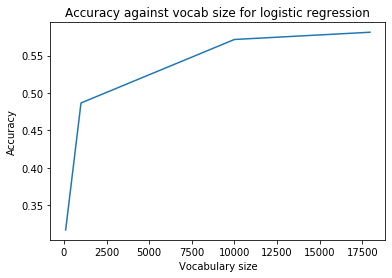

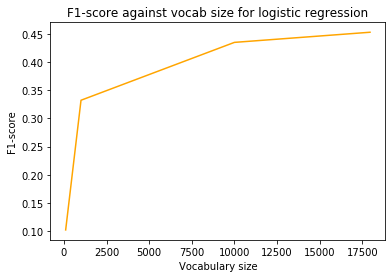

In [16]:
vocab_sizes = [len(vocab) for vocab in vocabs]
plt.plot(vocab_sizes, accs_logreg)
plt.ylabel('Accuracy')
plt.xlabel('Vocabulary size')
plt.title("Accuracy against vocab size for logistic regression")
plt.show()

plt.plot(vocab_sizes, f1s_logreg, color = "orange")
plt.ylabel('F1-score')
plt.xlabel('Vocabulary size')
plt.title("F1-score against vocab size for logistic regression")
plt.show()

### Build an MLP model with Keras

Disclosure: MLPs are technically not (in general) log-linear models

In [17]:
model = keras.Sequential([
    Input(shape=50),
    Dense(32, activation = "relu"),
    Dense(32, activation = "relu"),
    Dense(32, activation = "relu"),
    Dense(num_labels, activation = "softmax", name = "output")
])

In [18]:
metrics = ['acc']
loss = keras.losses.SparseCategoricalCrossentropy()
opt = keras.optimizers.Adam()
model.compile(optimizer = opt, loss = loss, metrics = metrics)

In [19]:
vocabs = [vocab_100, vocab_1000, vocab_10000, vocab_full]
accs_mlp = []
f1s_mlp = []
for vocab in vocabs:
    X_train = vectorize_and_pool_dataset(X_raw_train, vocab = vocab)
    X_test = vectorize_and_pool_dataset(X_raw_test, vocab = vocab)
    model.fit(X_train, y_train, batch_size=500, epochs=100, verbose = False)
    y_pred = model.predict(X_test)
    y_pred = np.array([np.argmax(pred) for pred in y_pred])
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average = "macro")
    print("Accuracy: ", acc)
    print("F1-score: ", f1)
    accs_mlp.append(acc)
    f1s_mlp.append(f1)

Accuracy:  0.33639439342677624
F1-score:  0.11768497113966188
Accuracy:  0.503302722732399
F1-score:  0.338807719048564
Accuracy:  0.5894957306267118
F1-score:  0.44478876212171514
Accuracy:  0.6007733204446593
F1-score:  0.46402491447714783


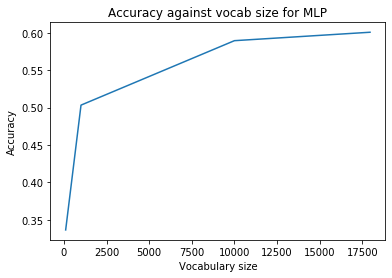

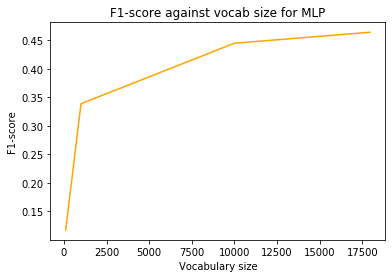

In [20]:
vocab_sizes = [len(vocab) for vocab in vocabs]
plt.plot(vocab_sizes, accs_mlp)
plt.ylabel('Accuracy')
plt.xlabel('Vocabulary size')
plt.title("Accuracy against vocab size for MLP")
plt.show()

plt.plot(vocab_sizes, f1s_mlp, color = "orange")
plt.ylabel('F1-score')
plt.xlabel('Vocabulary size')
plt.title("F1-score against vocab size for MLP")
plt.show()

### Why not also do a Perceptron

(Not a log-linear model, just for comparison)

Accuracy:  0.16143064282261962
F1-score:  0.06674503468935375
Accuracy:  0.3091670694377316
F1-score:  0.13460278908350348
Accuracy:  0.4667311100370549
F1-score:  0.28790837980813605
Accuracy:  0.36072176574834863
F1-score:  0.2656166581409396


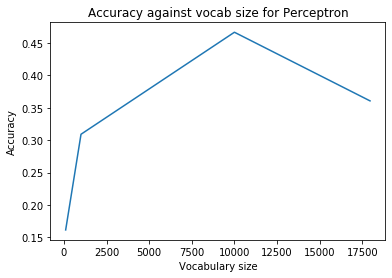

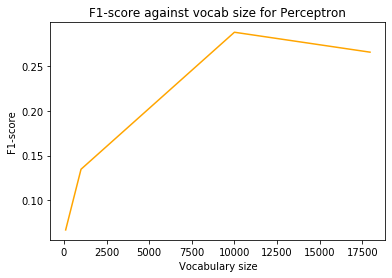

In [21]:
vocabs = [vocab_100, vocab_1000, vocab_10000, vocab_full]
accs = []
f1s = []
for vocab in vocabs:
    X_train = vectorize_and_pool_dataset(X_raw_train, vocab = vocab)
    X_test = vectorize_and_pool_dataset(X_raw_test, vocab = vocab)
    clf = Perceptron()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average = "macro")
    print("Accuracy: ", acc)
    print("F1-score: ", f1)
    accs.append(acc)
    f1s.append(f1)

vocab_sizes = [len(vocab) for vocab in vocabs]
plt.plot(vocab_sizes, accs)
plt.ylabel('Accuracy')
plt.xlabel('Vocabulary size')
plt.title("Accuracy against vocab size for Perceptron")
plt.show()

plt.plot(vocab_sizes, f1s, color = "orange")
plt.ylabel('F1-score')
plt.xlabel('Vocabulary size')
plt.title("F1-score against vocab size for Perceptron")
plt.show()

Performance actually decreased with largest vocab size, interesting

### ii)

Train the same set of log-linear models for each vocabulary size but this time,
with an L2 penalty on the models’ weights. Tune the regularizer’s coefficient to
maximize accuracy on the development set. Again plot the accuracy and macro
F-measure on the test set against the increasing vocabulary size.

I'll leave out the Perceptron from now on

### Logistic regression

In [22]:
vocabs = [vocab_100, vocab_1000, vocab_10000, vocab_full]
accs_logreg_l2 = []
f1s_logreg_l2 = []
for vocab in vocabs:
    X_train = vectorize_and_pool_dataset(X_raw_train, vocab = vocab)
    X_test = vectorize_and_pool_dataset(X_raw_test, vocab = vocab)
    clf = LogisticRegression()
    # Use pipeline to avoid data leakage through scaling using data in validation set
    steps = [("scaler", StandardScaler()), ("classifier", clf)]
    pipeline = Pipeline(steps = steps)
    params = {'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10]}
    grid = GridSearchCV(clf, param_grid = params, scoring = "accuracy", cv = 4) # Note, 4 folds will yield validation set of 20%
    grid.fit(X_train, y_train)
    # take model with best value of C and train on whole training set
    best_C = grid.best_params_['C']
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    clf = LogisticRegression()
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average = "macro")
    print("Accuracy: ", acc)
    print("F1-score: ", f1)
    accs_logreg_l2.append(acc)
    f1s_logreg_l2.append(f1)

/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

Accuracy:  0.3206057676816497
F1-score:  0.11012494787047586


/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

Accuracy:  0.4863863380054777
F1-score:  0.3390698112499216


/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

Accuracy:  0.5814403093281779
F1-score:  0.4605113163538755


/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

Accuracy:  0.5867568873852103
F1-score:  0.4712422374445085


/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [23]:
accs_logreg_l2, f1s_logreg_l2

([0.3206057676816497,
  0.4863863380054777,
  0.5814403093281779,
  0.5867568873852103],
 [0.11012494787047586,
  0.3390698112499216,
  0.4605113163538755,
  0.4712422374445085])

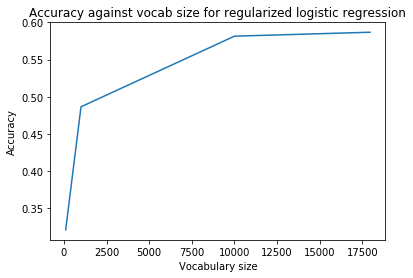

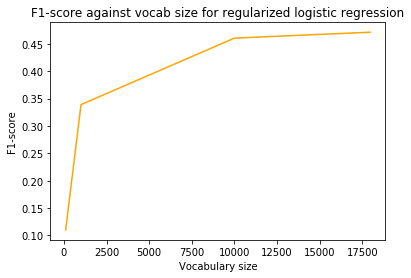

In [24]:
vocab_sizes = [len(vocab) for vocab in vocabs]
plt.plot(vocab_sizes, accs_logreg_l2)
plt.ylabel('Accuracy')
plt.xlabel('Vocabulary size')
plt.title("Accuracy against vocab size for regularized logistic regression")
plt.show()

plt.plot(vocab_sizes, f1s_logreg_l2, color = "orange")
plt.ylabel('F1-score')
plt.xlabel('Vocabulary size')
plt.title("F1-score against vocab size for regularized logistic regression")
plt.show()

Slightly higher scores but do not change relationship between vocab size and score

### MLP

In [25]:
def build_and_compile(reg_strength):
    model = keras.Sequential([
        Input(shape=50),
        Dense(32, activation = "relu", kernel_regularizer = l2(reg_strength), 
              bias_regularizer = l2(reg_strength)),
        Dense(32, activation = "relu", kernel_regularizer = l2(reg_strength), 
              bias_regularizer = l2(reg_strength)),
        Dense(32, activation = "relu", kernel_regularizer = l2(reg_strength), 
              bias_regularizer = l2(reg_strength)),
        Dense(num_labels, activation = "softmax", name = "output")
    ])
    metrics = ['acc']
    loss = keras.losses.SparseCategoricalCrossentropy()
    opt = keras.optimizers.Adam()
    model.compile(optimizer = opt, loss = loss, metrics = metrics)
    return model

In [26]:
vocabs = [vocab_100, vocab_1000, vocab_10000, vocab_full]
accs_mlp_l2 = []
f1s_mlp_l2 = []
reg_grid = [0.001, 0.01, 0.1, 1, 10]
EPOCHS = 100
for vocab in vocabs:
    X_train = vectorize_and_pool_dataset(X_raw_train, vocab = vocab)
    X_test = vectorize_and_pool_dataset(X_raw_test, vocab = vocab)
    val_accs = []
    print("Starting cross validation...")
    for r in reg_grid:
        print("Cross validation for r = ", r)
        model = build_and_compile(r)
        X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, 
                                                                  test_size = 0.25, random_state = SEED)
        model.fit(X_train_sub, y_train_sub, batch_size=500, epochs=EPOCHS, verbose = False)
        y_pred = model.predict(X_val)
        y_pred = np.array([np.argmax(pred) for pred in y_pred])
        acc = accuracy_score(y_val, y_pred)
        val_accs.append(acc)
    best_r = reg_grid[np.argmax(val_accs)]
    model = build_and_compile(best_r)
    model.fit(X_train, y_train, batch_size=500, epochs=EPOCHS, verbose = False)
    y_pred = model.predict(X_test)
    y_pred = np.array([np.argmax(pred) for pred in y_pred])
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average = "macro")
    print("Accuracy: ", acc)
    print("F1-score: ", f1)
    accs_mlp_l2.append(acc)
    f1s_mlp_l2.append(f1)

Starting cross validation...
Cross validation for r =  0.001
Cross validation for r =  0.01
Cross validation for r =  0.1
Cross validation for r =  1
Cross validation for r =  10
Accuracy:  0.3367166102787176
F1-score:  0.10879221113411841
Starting cross validation...
Cross validation for r =  0.001
Cross validation for r =  0.01
Cross validation for r =  0.1
Cross validation for r =  1
Cross validation for r =  10
Accuracy:  0.49331400032221684
F1-score:  0.311210137207918
Starting cross validation...
Cross validation for r =  0.001
Cross validation for r =  0.01
Cross validation for r =  0.1
Cross validation for r =  1
Cross validation for r =  10
Accuracy:  0.5774125986789109
F1-score:  0.3970222215081566
Starting cross validation...
Cross validation for r =  0.001
Cross validation for r =  0.01
Cross validation for r =  0.1
Cross validation for r =  1
Cross validation for r =  10
Accuracy:  0.5783792492347349
F1-score:  0.40903759346836155


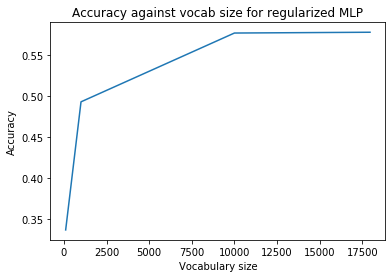

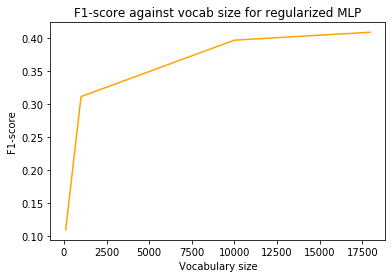

In [27]:
vocab_sizes = [len(vocab) for vocab in vocabs]
plt.plot(vocab_sizes, accs_mlp_l2)
plt.ylabel('Accuracy')
plt.xlabel('Vocabulary size')
plt.title("Accuracy against vocab size for regularized MLP")
plt.show()

plt.plot(vocab_sizes, f1s_mlp_l2, color = "orange")
plt.ylabel('F1-score')
plt.xlabel('Vocabulary size')
plt.title("F1-score against vocab size for regularized MLP")
plt.show()

### iii)

Provide an analysis of the results from above. At what point do we see diminishing returns in evaluation metrics when increasing the vocabulary size? Does regularization appear to help some of the classifiers? If so, is there a clear relationship between vocabulary size and the difference in evaluation metrics for regularized vs. unregularized models?

We don't see a decrease in performance with increasing vocabulary size for any of the models (except the perceptron), regularized or not. This might be since words that do not occur so often might be more discriminatory, and therefore helps in prediction. 

Interestingly, regularization does seem to help the logistic regression classifier (which sees higher scores when optimized for regularization) but not the MLP (which achieves lower scores when optimized for regularization).

Let's plot the relationship between vocab size and difference in accuracy for the regularized and non-regularized logistic regression:

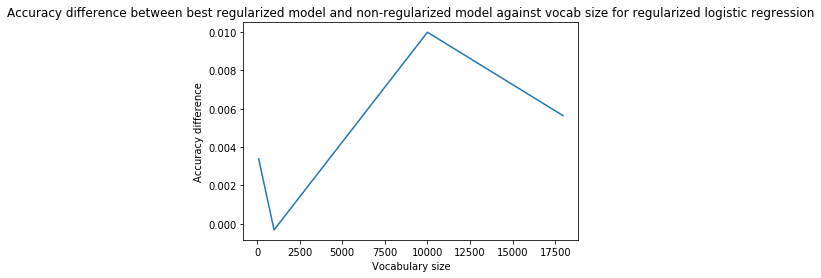

In [28]:
vocab_sizes = [len(vocab) for vocab in vocabs]
diff = np.array(accs_logreg_l2) - np.array(accs_logreg)
plt.plot(vocab_sizes, diff)
plt.ylabel('Accuracy difference')
plt.xlabel('Vocabulary size')
plt.title("Accuracy difference between best regularized model and non-regularized model " +
          "against vocab size for regularized logistic regression")
plt.show()

So it seems that the benefits of regularizing reaches a peak, after which it diminishes